# set up environment

In [1]:
# !pip install -r requirements.txt
# !pip install --upgrade pip

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
from pyspark.ml.feature import StringIndexer, VectorAssembler,OneHotEncoder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [3]:
spark = SparkSession.builder.appName("bigdata-project_withSparkML").getOrCreate() 

24/12/11 11:11:14 WARN Utils: Your hostname, VM resolves to a loopback address: 127.0.0.1; using 192.168.1.250 instead (on interface en0)
24/12/11 11:11:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/11 11:11:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.csv('hdfs://localhost:9000/usr/baonguyen/data.csv', header=True, inferSchema=True)

# Prepare Data

## Explore and Preprocess

In [5]:
df.count() , df.columns

(4920,
 ['itching',
  'skin_rash',
  'nodal_skin_eruptions',
  'continuous_sneezing',
  'shivering',
  'chills',
  'joint_pain',
  'stomach_pain',
  'acidity',
  'ulcers_on_tongue',
  'muscle_wasting',
  'vomiting',
  'burning_micturition',
  'spotting_ urination',
  'fatigue',
  'weight_gain',
  'anxiety',
  'cold_hands_and_feets',
  'mood_swings',
  'weight_loss',
  'restlessness',
  'lethargy',
  'patches_in_throat',
  'irregular_sugar_level',
  'cough',
  'high_fever',
  'sunken_eyes',
  'breathlessness',
  'sweating',
  'dehydration',
  'indigestion',
  'headache',
  'yellowish_skin',
  'dark_urine',
  'nausea',
  'loss_of_appetite',
  'pain_behind_the_eyes',
  'back_pain',
  'constipation',
  'abdominal_pain',
  'diarrhoea',
  'mild_fever',
  'yellow_urine',
  'yellowing_of_eyes',
  'acute_liver_failure',
  'swelling_of_stomach',
  'swelled_lymph_nodes',
  'malaise',
  'blurred_and_distorted_vision',
  'phlegm',
  'throat_irritation',
  'redness_of_eyes',
  'sinus_pressure',
  'r

In [6]:
from pyspark.sql.functions import col

# Identify columns to drop
columns_to_drop = []

for cols in df.columns:
    # Skip the 'prognosis' column (label column)
    if cols == 'prognosis':
        continue
    
    # Get distinct values in the column
    unique_values = [row[0] for row in df.select(cols).distinct().collect()]
    
    # Check if the column has exactly two unique values and they are [0, 1]
    if len(unique_values) != 2 or set(unique_values) != {0, 1}:
        columns_to_drop.append(cols)

# Drop unwanted columns
df = df.drop(*columns_to_drop)

# Show the resulting DataFrame
print(f"Dropped columns: {columns_to_drop}")
df.show(5)

Dropped columns: ['Unnamed: 133']


24/12/11 11:11:30 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+---------+--------------------+-------------------+---------+------+----------+------------+-------+----------------+--------------+--------+-------------------+-------------------+-------+-----------+-------+--------------------+-----------+-----------+------------+--------+-----------------+---------------------+-----+----------+-----------+--------------+--------+-----------+-----------+--------+--------------+----------+------+----------------+--------------------+---------+------------+--------------+---------+----------+------------+-----------------+-------------------+-------------------+-------------------+-------+----------------------------+------+-----------------+---------------+--------------+----------+----------+----------+-----------------+---------------+---------------------------+-------------------+------------+------------------+---------+---------+------+--------+-------+------------+---------------------+-------------------+----------------+------------

In [7]:
from pyspark.sql.functions import col, sum

# Count null values for each column
null_counts = df.select(
    [sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]
)

# Collect the null counts as a dictionary
null_columns = null_counts.first().asDict()

# Filter columns with non-zero null counts
null_columns_with_counts = {col_name: count for col_name, count in null_columns.items() if count > 0}

# Print results
if null_columns_with_counts:
    print("Columns with null values and their counts:")
    for col_name, count in null_columns_with_counts.items():
        print(f"{col_name}: {count}")
else:
    print("No columns with null values found.")

No columns with null values found.


24/12/11 11:11:32 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [8]:
features = [cols for cols in df.columns if cols !='prognosis']


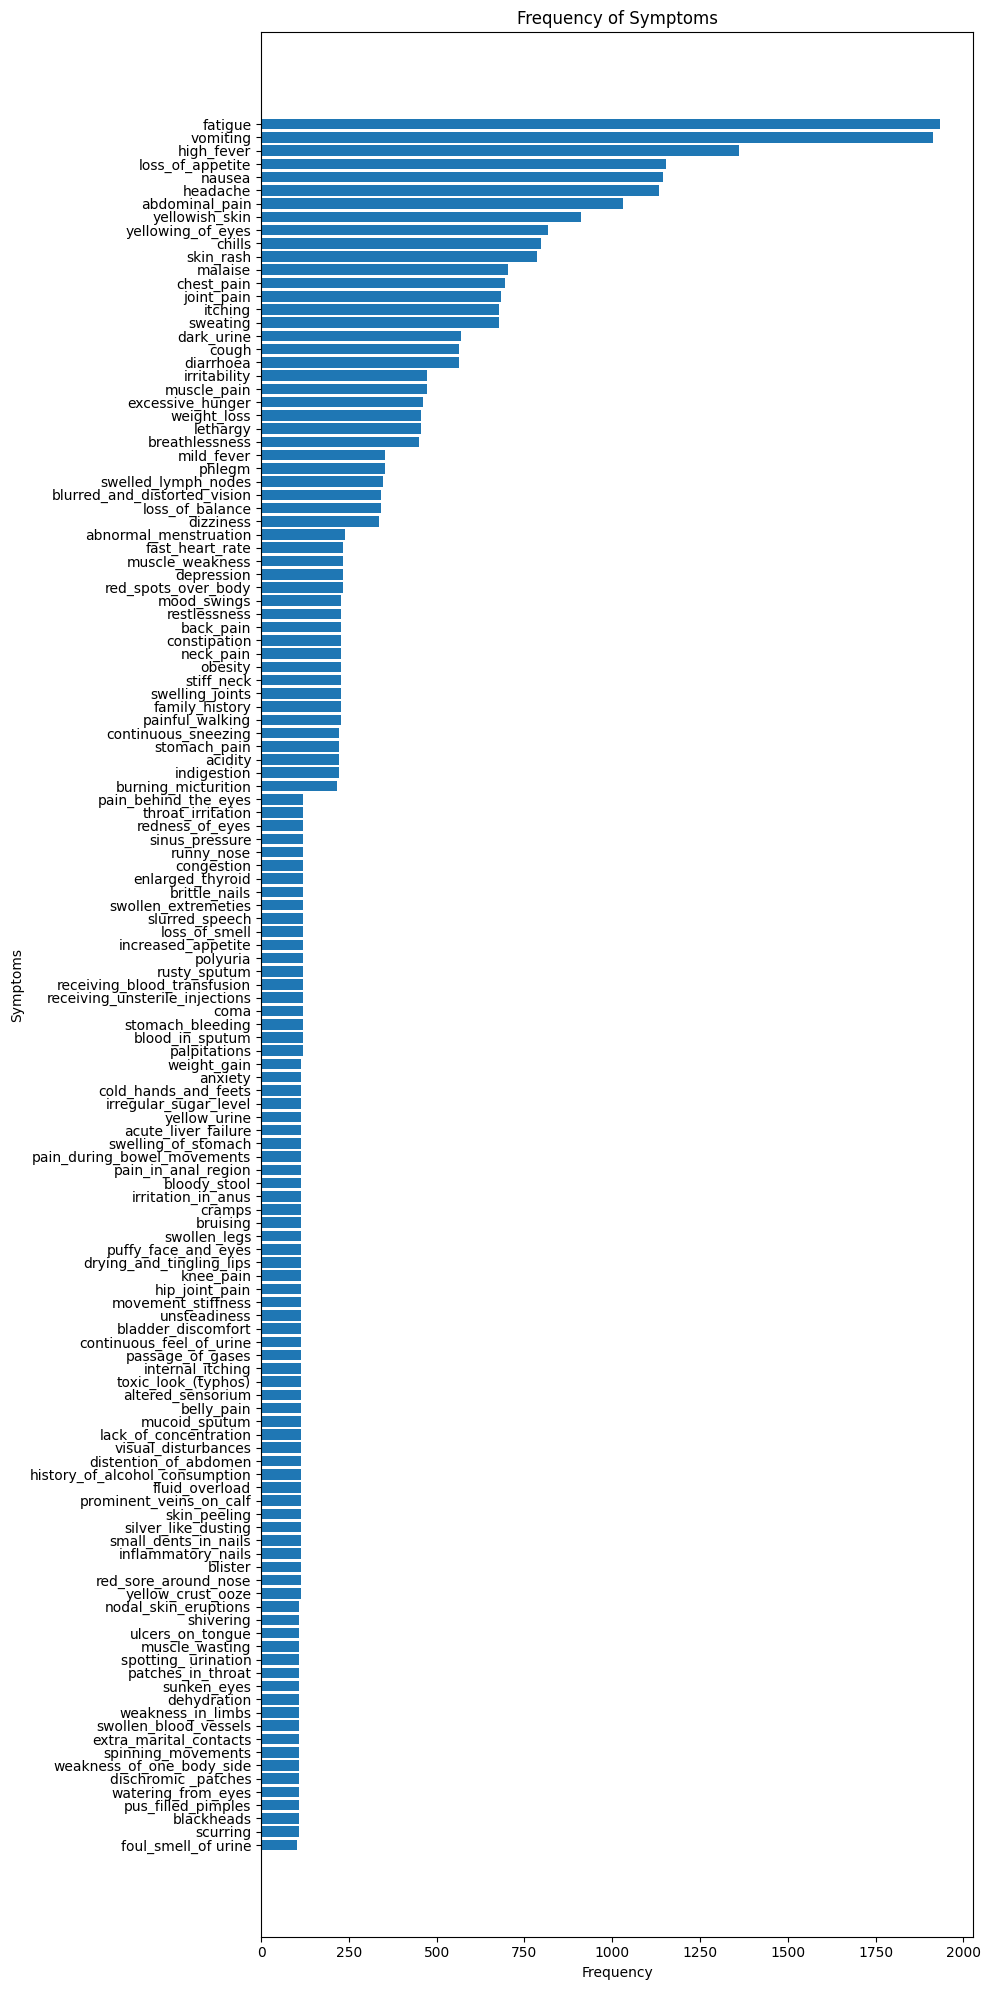

In [9]:
from pyspark.sql.functions import col, sum
import matplotlib.pyplot as plt

# Dictionary to store frequencies
frequency = {}

# Assuming 'features' is a list of feature column names
for cols in features:
    frequency[cols] = df.select(sum(col(cols)).alias("frequency")).collect()[0]["frequency"]

# Sort the frequency dictionary in descending order
sorted_frequency = dict(sorted(frequency.items(), key=lambda item: item[1], reverse=True))

# Extract column names and their corresponding frequencies
columns = list(sorted_frequency.keys())
frequencies = list(sorted_frequency.values())

# Plot the frequencies as a horizontal bar chart
plt.figure(figsize=(10, 20))
plt.barh(columns, frequencies)
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest frequency at the top
plt.title("Frequency of Symptoms")
plt.xlabel("Frequency")
plt.ylabel("Symptoms")
plt.tight_layout()
plt.show()

In [10]:
from pyspark.sql.functions import col, sum, lit
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure Spark DataFrame `df` and feature list `features` are defined
# Aggregate symptom frequencies for all prognoses in one Spark job
aggregated_data = []
for symptom in features:  # Assuming 'features' contains the symptom columns
    symptom_df = (
        df.groupBy("prognosis")
        .agg(sum(col(symptom)).alias("frequency"))
        .withColumn("Symptom", lit(symptom))
    )
    aggregated_data.append(symptom_df)

# Combine all aggregated data into a single DataFrame
combined_df = aggregated_data[0]
for df_part in aggregated_data[1:]:
    combined_df = combined_df.union(df_part)

# Collect the aggregated data to the driver as a Pandas DataFrame
result_df = combined_df.toPandas()

# Directory to save plots
output_dir = "prognosis"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Process and save plots for each prognosis
for prognosis in result_df["prognosis"].unique():
    prognosis_data = result_df[result_df["prognosis"] == prognosis]
    sorted_data = prognosis_data.sort_values(by="frequency", ascending=False).head(5)

    # Plot the horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_data["Symptom"], sorted_data["frequency"], color="skyblue")
    plt.gca().invert_yaxis()  # Highest frequency at the top
    plt.title(f"Top 5 Symptoms for Prognosis: {prognosis}")
    plt.xlabel("Frequency")
    plt.ylabel("Symptoms")
    plt.tight_layout()

    # Save the plot in the specified folder
    file_path = os.path.join(output_dir, f"{prognosis}_top5_symptoms.png")
    plt.savefig(file_path)
    plt.close()  # Close the plot to avoid displaying it during loop execution

print(f"Plots saved in the '{output_dir}' folder.")

24/12/11 11:11:57 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


Plots saved in the 'prognosis' folder.


In [11]:
# turn label column to numeric
labelIndexer = StringIndexer(inputCol="prognosis", outputCol="label")
indexer_label = labelIndexer.fit(df)
df = indexer_label.transform(df)


df = df.drop('prognosis')

train , test = df.randomSplit([0.8,0.2],seed=1)

print(indexer_label.labels)

['(vertigo) Paroymsal  Positional Vertigo', 'AIDS', 'Acne', 'Alcoholic hepatitis', 'Allergy', 'Arthritis', 'Bronchial Asthma', 'Cervical spondylosis', 'Chicken pox', 'Chronic cholestasis', 'Common Cold', 'Dengue', 'Diabetes ', 'Dimorphic hemmorhoids(piles)', 'Drug Reaction', 'Fungal infection', 'GERD', 'Gastroenteritis', 'Heart attack', 'Hepatitis B', 'Hepatitis C', 'Hepatitis D', 'Hepatitis E', 'Hypertension ', 'Hyperthyroidism', 'Hypoglycemia', 'Hypothyroidism', 'Impetigo', 'Jaundice', 'Malaria', 'Migraine', 'Osteoarthristis', 'Paralysis (brain hemorrhage)', 'Peptic ulcer diseae', 'Pneumonia', 'Psoriasis', 'Tuberculosis', 'Typhoid', 'Urinary tract infection', 'Varicose veins', 'hepatitis A']


In [12]:
# Show the mapping of labels and their corresponding numeric values
label_mapping = list(enumerate(indexer_label.labels))
for label_number, label_name in label_mapping:
    print(f"Numeric: {label_number}, Label: {label_name}")


Numeric: 0, Label: (vertigo) Paroymsal  Positional Vertigo
Numeric: 1, Label: AIDS
Numeric: 2, Label: Acne
Numeric: 3, Label: Alcoholic hepatitis
Numeric: 4, Label: Allergy
Numeric: 5, Label: Arthritis
Numeric: 6, Label: Bronchial Asthma
Numeric: 7, Label: Cervical spondylosis
Numeric: 8, Label: Chicken pox
Numeric: 9, Label: Chronic cholestasis
Numeric: 10, Label: Common Cold
Numeric: 11, Label: Dengue
Numeric: 12, Label: Diabetes 
Numeric: 13, Label: Dimorphic hemmorhoids(piles)
Numeric: 14, Label: Drug Reaction
Numeric: 15, Label: Fungal infection
Numeric: 16, Label: GERD
Numeric: 17, Label: Gastroenteritis
Numeric: 18, Label: Heart attack
Numeric: 19, Label: Hepatitis B
Numeric: 20, Label: Hepatitis C
Numeric: 21, Label: Hepatitis D
Numeric: 22, Label: Hepatitis E
Numeric: 23, Label: Hypertension 
Numeric: 24, Label: Hyperthyroidism
Numeric: 25, Label: Hypoglycemia
Numeric: 26, Label: Hypothyroidism
Numeric: 27, Label: Impetigo
Numeric: 28, Label: Jaundice
Numeric: 29, Label: Malar

# Analyze data

In [13]:

class ModelComparisonPipeline:
    def __init__(self, spark_session, train, test, top_features: list, label_column: str):
        self.spark = spark_session
        self.models = []  # Store models for comparison
        self.train = train
        self.test = test
        self.top_features = top_features
        self.label_column = label_column

    def _build_pipeline(self, model):
        # Step 1: Assemble features
        assembler = VectorAssembler(
            inputCols=self.top_features, outputCol="assembled_features"
        )
        model.setFeaturesCol("assembled_features")
        # Step 2: Build pipeline with assembler and model
        pipeline = Pipeline(stages=[assembler, model])
        return pipeline

    def compare_models(self, models_with_params):
        # Split the data into training and testing sets
        train_df, test_df = self.train, self.test

        # Initialize evaluator
        evaluator = MulticlassClassificationEvaluator(
            labelCol=self.label_column, predictionCol="prediction", metricName="accuracy"
        )

        # Iterate through models and evaluate
        results = []
        for model_name, model, param_grid in models_with_params:
            print(f"Training and evaluating {model_name}...")

            # Build pipeline with the current model
            # pipeline = self._build_pipeline(model)
            pipeline = Pipeline(stages=[model])

            # Train the model
            trained_model = pipeline.fit(train_df)

            # Evaluate the model
            predictions = trained_model.transform(test_df)
            accuracy = evaluator.evaluate(predictions)
            print(f"{model_name} Accuracy: {accuracy:.2f}")

            # Store results
            results.append((model_name, accuracy, trained_model))
            #    Define CrossValidator with the model and its parameter grid
            # cv = CrossValidator(
            #     estimator=pipeline,
            #     estimatorParamMaps=param_grid,
            #     evaluator=MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy"),
            #     numFolds=3  # Adjust the number of folds as needed
            # )

            # # Fit the model and evaluate
            # cv_model = cv.fit(train)
            # accuracy = cv_model.avgMetrics[0]  # Access accuracy from CrossValidator

        # Save results
        results.append((model_name, accuracy, trained_model))
        # Return sorted results by accuracy
        results.sort(key=lambda x: x[1], reverse=True)
        return results

In [14]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder

# Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="label", maxBins=45)

# Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label", maxBins=45)

# Naive Bayes Classifier
nb = NaiveBayes(featuresCol="features", labelCol="label")

# Assemble features
assembler = VectorAssembler(inputCols=features, outputCol="features")
train = assembler.transform(train)
test = assembler.transform(test)

# Parameter Grid for Decision Tree
dt_param_grid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [2, 5, 10]) \
    .addGrid(dt.maxBins, [10, 20, 40]) \
    .build()

# Parameter Grid for Random Forest
rf_param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# Parameter Grid for Naive Bayes
nb_param_grid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1.0, 2.0]) \
    .build()



In [15]:
# Collect all models and parameter grids for cross-validation
models_with_params = [
    ("Decision Tree", dt, dt_param_grid),
    ("Random Forest", rf, rf_param_grid),
    ("Naive Bayes", nb, nb_param_grid)
]

# Define evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)

In [16]:
import os
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, lit
import pandas as pd

# Ensure the folder exists
metrics_folder = "metrics"
os.makedirs(metrics_folder, exist_ok=True)

train.cache()

# Compare models
best_models = []

for model_name, model, param_grid in models_with_params:
    print(f"Training and evaluating {model_name}...")

    # Define pipeline
    pipeline = Pipeline(stages=[model])

    # Define CrossValidator
    cv = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=5  # Adjust number of folds as needed
    )

    # Fit model using CrossValidator
    cv_model = cv.fit(train)

    # Get best model
    best_model = cv_model.bestModel

    # Specify the path to save the best model
    output_path = f"hdfs://localhost:9000/usr/baonguyen/models/{model_name}"

    # Save the best model
    best_model.write().overwrite().save(output_path)
    print(f"Best model saved to {output_path}")

    # Evaluate on test data
    predictions = best_model.transform(test)
    accuracy = evaluator.evaluate(predictions)
    print(f"{model_name} Test Accuracy: {accuracy:.2f}")

    # Compute precision and recall for each class
    classes = predictions.select("label").distinct().orderBy("label").rdd.flatMap(lambda x: x).collect()
    class_labels = []
    precisions = []
    recalls = []

    for cls in classes:
        # Precision
        precision_evaluator = MulticlassClassificationEvaluator(
            labelCol="label",
            predictionCol="prediction",
            metricName="precisionByLabel"
        )
        precision = precision_evaluator.evaluate(predictions, {precision_evaluator.metricLabel: cls})

        # Recall
        recall_evaluator = MulticlassClassificationEvaluator(
            labelCol="label",
            predictionCol="prediction",
            metricName="recallByLabel"
        )
        recall = recall_evaluator.evaluate(predictions, {recall_evaluator.metricLabel: cls})

        class_labels.append(cls)
        precisions.append(precision)
        recalls.append(recall)

    # Create a DataFrame for class-specific metrics
    metrics_df = pd.DataFrame({
        "Class": class_labels,
        "Precision": precisions,
        "Recall": recalls
    })

    # Save metrics to CSV
    metrics_file = os.path.join(metrics_folder, f"{model_name}_metrics.csv")
    metrics_df.to_csv(metrics_file, index=False)
    print(f"Class-specific metrics saved to: {metrics_file}")

    # Store the best model and its accuracy
    best_models.append((model_name, accuracy, best_model))

# Sort models by accuracy
best_models.sort(key=lambda x: x[1], reverse=True)

# Print results
print("\nModel Comparison Results:")
for model_name, accuracy, _ in best_models:
    print(f"{model_name}: {accuracy:.2f}")

Training and evaluating Decision Tree...


Best model saved to hdfs://localhost:9000/usr/baonguyen/models/Decision Tree
Decision Tree Test Accuracy: 0.25
Class-specific metrics saved to: metrics/Decision Tree_metrics.csv
Training and evaluating Random Forest...


24/12/11 11:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1064.9 KiB
24/12/11 11:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1165.7 KiB
24/12/11 11:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1261.4 KiB
24/12/11 11:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1365.8 KiB
24/12/11 11:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1466.0 KiB
24/12/11 11:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1575.6 KiB
24/12/11 11:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1680.7 KiB
24/12/11 11:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1791.6 KiB
24/12/11 11:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1916.8 KiB
24/12/11 11:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1434.5 KiB
24/12/11 11:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1073.3 KiB
24/12/11 11:12:55 WAR

Best model saved to hdfs://localhost:9000/usr/baonguyen/models/Random Forest


24/12/11 11:13:44 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


Random Forest Test Accuracy: 1.00


24/12/11 11:13:45 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/11 11:13:46 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/11 11:13:46 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/11 11:13:46 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/11 11:13:46 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/11 11:13:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/11 11:13:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/11 11:13:48 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/11 11:13:48 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/11 11:13:48 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/11 11:13:48 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/12/11 11:13:49 WARN DAGScheduler: Broadcasting larg

Class-specific metrics saved to: metrics/Random Forest_metrics.csv
Training and evaluating Naive Bayes...


24/12/11 11:14:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/11 11:14:07 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Best model saved to hdfs://localhost:9000/usr/baonguyen/models/Naive Bayes
Naive Bayes Test Accuracy: 1.00
Class-specific metrics saved to: metrics/Naive Bayes_metrics.csv

Model Comparison Results:
Random Forest: 1.00
Naive Bayes: 1.00
Decision Tree: 0.25


# Make prediction 

In [17]:
df_test = spark.read.csv('hdfs://localhost:9000/usr/baonguyen/datatest.csv',header=True,inferSchema=True)
df_test = df_test.drop(*columns_to_drop)
df_test = indexer_label.transform(df_test)
test_data = df_test
test_data = assembler.transform(test_data)

In [19]:
from pyspark.sql.functions import col
from pyspark.ml import PipelineModel
# Assuming you have a trained model and a test dataset
# Replace 'model' with your trained model and 'test' with your test dataset

model_path = "hdfs://localhost:9000/usr/baonguyen/models/Naive Bayes"

# Load the pipeline model
pipeline_model = PipelineModel.load(model_path)

# Make predictions on the test dataset
predictions = pipeline_model.transform(test_data)



# Show predictions with numeric and original labels
# Use the label mapping to convert numeric predictions back to original labels
predictions_with_labels = predictions.select(
    col("features"),
    col('label'),
    col("prediction").alias("predicted_numeric"),
    col("probability").alias("predicted_probabilities")
)

# Map numeric predictions back to original labels
label_mapping = list(enumerate(indexer_label.labels))
numeric_to_label = {num: label for num, label in label_mapping}

# Convert predicted numeric to original labels
def map_numeric_to_label(numeric_value):
    return numeric_to_label.get(int(numeric_value), "Unknown")

# Register UDF for mapping
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

map_to_label_udf = udf(map_numeric_to_label, StringType())

# Add original label to predictions
final_predictions = predictions_with_labels.withColumn(
    "predicted_label",
    map_to_label_udf(col("predicted_numeric"))
)

# Show the results
final_predictions.select("features",'label' ,"predicted_numeric", "predicted_label").show(truncate=False)

+--------------------------------------------------------------------------------------------------------+-----+-----------------+----------------------------+
|features                                                                                                |label|predicted_numeric|predicted_label             |
+--------------------------------------------------------------------------------------------------------+-----+-----------------+----------------------------+
|(131,[0,1,2,101],[1.0,1.0,1.0,1.0])                                                                     |15.0 |15.0             |Fungal infection            |
|(131,[3,4,5,102],[1.0,1.0,1.0,1.0])                                                                     |4.0  |4.0              |Allergy                     |
|(131,[7,8,9,11,24,55],[1.0,1.0,1.0,1.0,1.0,1.0])                                                        |16.0 |16.0             |GERD                        |
|(131,[0,11,32,34,35,39,43],[1.0,1.0,1.0